# **Import Libraries and modules**

# GRADCAM

Let's start with a pretrained VGG model

In [1]:
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
import numpy as np
import cv2

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


1.  Loading helper functions
2.  Load VGG
3. Load Image
4. Rescale image to 224x224x3 (VGG's expectation, why?)
5. Use expand_dims to convert image to a batch of size 1
6. Preprocesing normalizes our input image by subtracting mean RGB values

In [3]:
model = VGG16(weights="imagenet")
from skimage import io
tonyStark = io.imread('/content/drive/My Drive/Colab Notebooks/10. Visualizations/images/TonyStark.jpg')
tonyStark = cv2.resize(tonyStark, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
x = image.img_to_array(tonyStark)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

W0720 01:38:41.182640 140471819151232 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0720 01:38:41.223887 140471819151232 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0720 01:38:41.232543 140471819151232 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0720 01:38:41.272296 140471819151232 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



553467904/553467096 [==============================] - 13s 0us/step


W0720 01:38:55.092859 140471819151232 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0720 01:38:55.094125 140471819151232 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



Lets view the summary of the model

In [4]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

1. We get the predictions for the image
2. We take the topmost class index
3. Take output from the final convolutional layer

In [5]:
preds = model.predict(x)
class_idx = np.argmax(preds[0])
print(class_idx)
class_output = model.output[:, class_idx]
last_conv_layer = model.get_layer("block5_conv3")

837


1. Compute the gradient of the class output value with respect to the feature map
2. Pool the gradients over all the axies leaving out the channel dimension
3. Weigh the output feature map with the computed gradient values

In [6]:
from keras import backend as K

grads = K.gradients(class_output, last_conv_layer.output)[0]
print(grads.shape)
pooled_grads = K.mean(grads, axis=(0, 1, 2))
print(pooled_grads.shape)
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([x])

for i in range(512):
  conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

(?, 14, 14, 512)
(512,)


1. Average the weighted feature map along the channel dimension resulting in a heat map of size 14x14 
2. Normalize the heat map to make the values between 0 and 1

In [8]:
heatmap = np.mean(conv_layer_output_value, axis = -1)
print(conv_layer_output_value.shape)
print(heatmap.shape)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

(14, 14, 512)
(14, 14)


Show the results

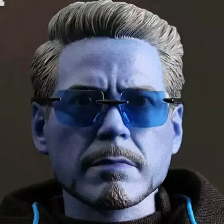

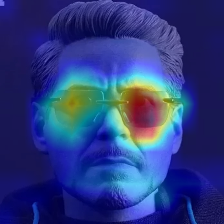

In [9]:
heatmap = cv2.resize(heatmap, (tonyStark.shape[1], tonyStark.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(tonyStark, 0.5, heatmap, 0.5, 0)
from google.colab.patches import cv2_imshow
cv2_imshow(tonyStark)
cv2_imshow(superimposed_img)

Now we will Build GradCAM images for the one layer before the one we used, and one layer before this one

On block5_conv2 layer

837
(?, 14, 14, 512)
(512,)
(14, 14, 512)
(14, 14)


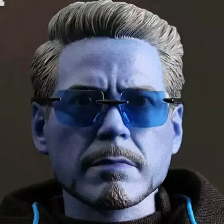

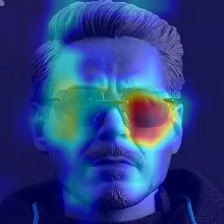

In [10]:
preds = model.predict(x)
class_idx = np.argmax(preds[0])
print(class_idx)
class_output = model.output[:, class_idx]
last_conv_layer = model.get_layer("block5_conv2")

from keras import backend as K

grads = K.gradients(class_output, last_conv_layer.output)[0]
print(grads.shape)
pooled_grads = K.mean(grads, axis=(0, 1, 2))
print(pooled_grads.shape)
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([x])

for i in range(512):
  conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
  
heatmap = np.mean(conv_layer_output_value, axis = -1)
print(conv_layer_output_value.shape)
print(heatmap.shape)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

heatmap = cv2.resize(heatmap, (tonyStark.shape[1], tonyStark.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(tonyStark, 0.5, heatmap, 0.5, 0)
from google.colab.patches import cv2_imshow
cv2_imshow(tonyStark)
cv2_imshow(superimposed_img)

On block5_conv1 layer

837
(?, 14, 14, 512)
(512,)
(14, 14, 512)
(14, 14)


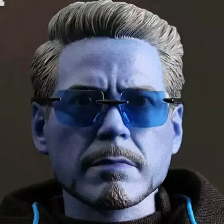

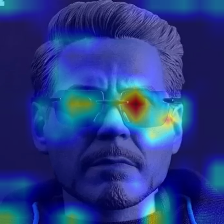

In [11]:
preds = model.predict(x)
class_idx = np.argmax(preds[0])
print(class_idx)
class_output = model.output[:, class_idx]
last_conv_layer = model.get_layer("block5_conv1")

from keras import backend as K

grads = K.gradients(class_output, last_conv_layer.output)[0]
print(grads.shape)
pooled_grads = K.mean(grads, axis=(0, 1, 2))
print(pooled_grads.shape)
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([x])

for i in range(512):
  conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
  
heatmap = np.mean(conv_layer_output_value, axis = -1)
print(conv_layer_output_value.shape)
print(heatmap.shape)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

heatmap = cv2.resize(heatmap, (tonyStark.shape[1], tonyStark.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(tonyStark, 0.5, heatmap, 0.5, 0)
from google.colab.patches import cv2_imshow
cv2_imshow(tonyStark)
cv2_imshow(superimposed_img)

In [13]:
!pip install keract

W0720 01:43:51.681211 140471819151232 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



sunglasses (25.281476974487305)
input_3:0 (224, 224, 3) -> Skipped. First dimension is not 1.
block1_conv1_2/Relu:0 (1, 224, 224, 64) 


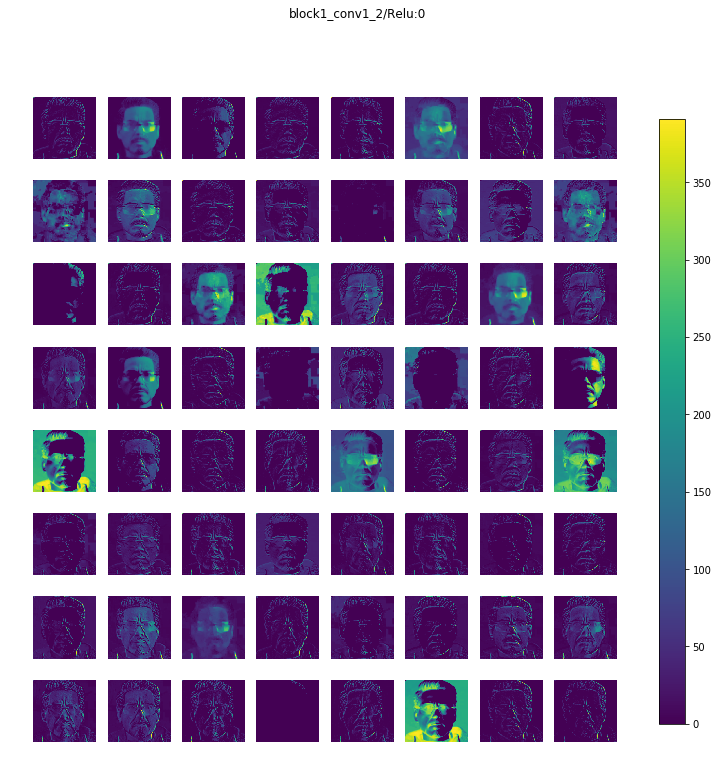

block1_conv2_2/Relu:0 (1, 224, 224, 64) 


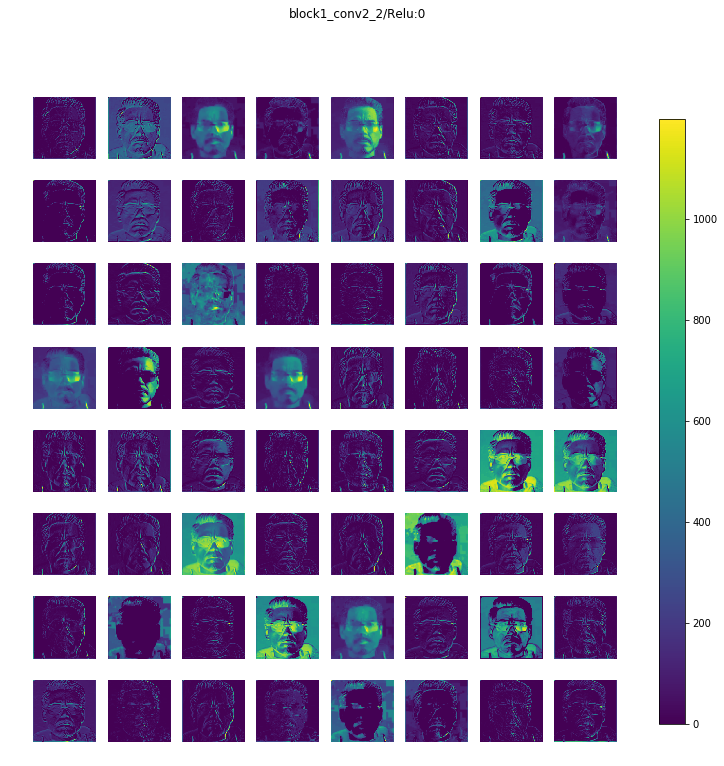

block1_pool_2/MaxPool:0 (1, 112, 112, 64) 


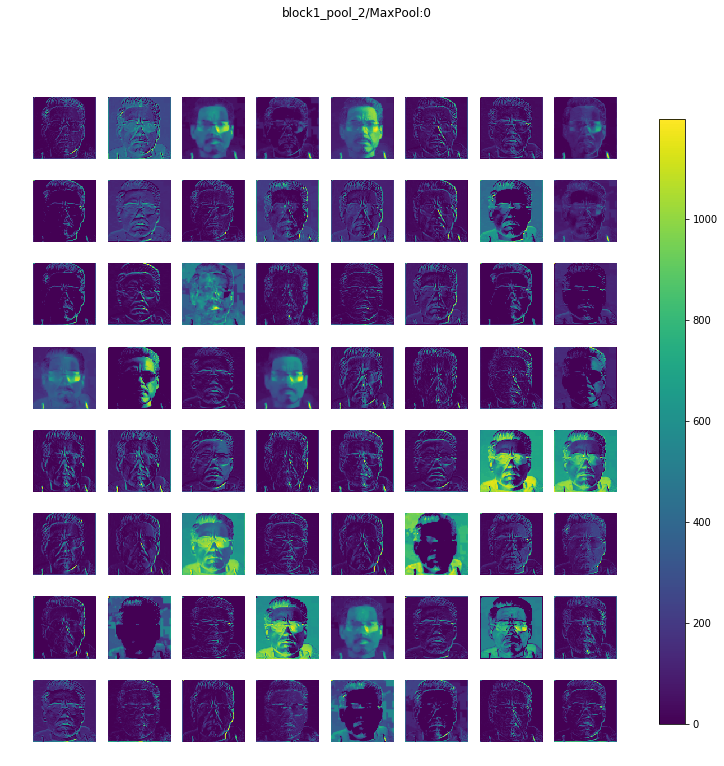

block2_conv1_2/Relu:0 (1, 112, 112, 128) 


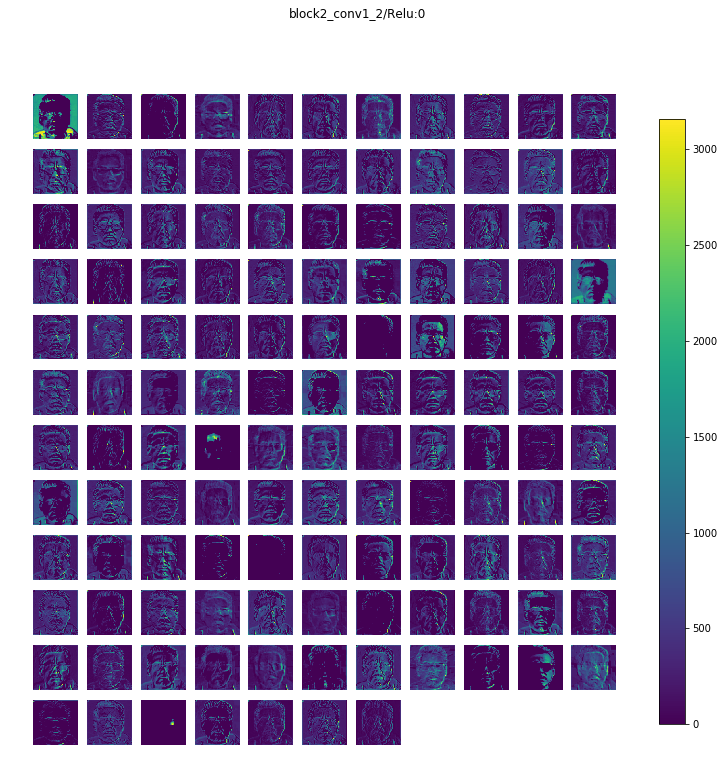

block2_conv2_2/Relu:0 (1, 112, 112, 128) 


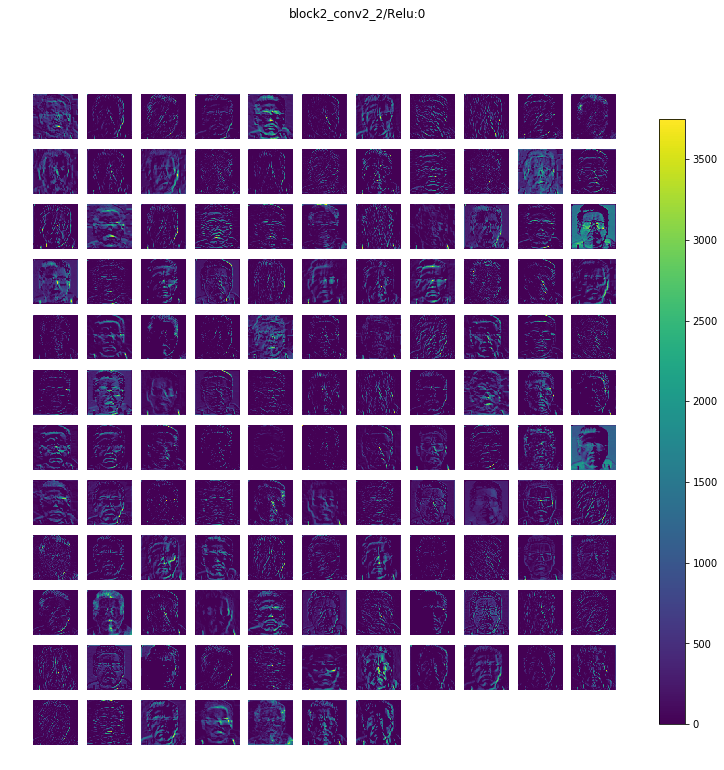

block2_pool_2/MaxPool:0 (1, 56, 56, 128) 


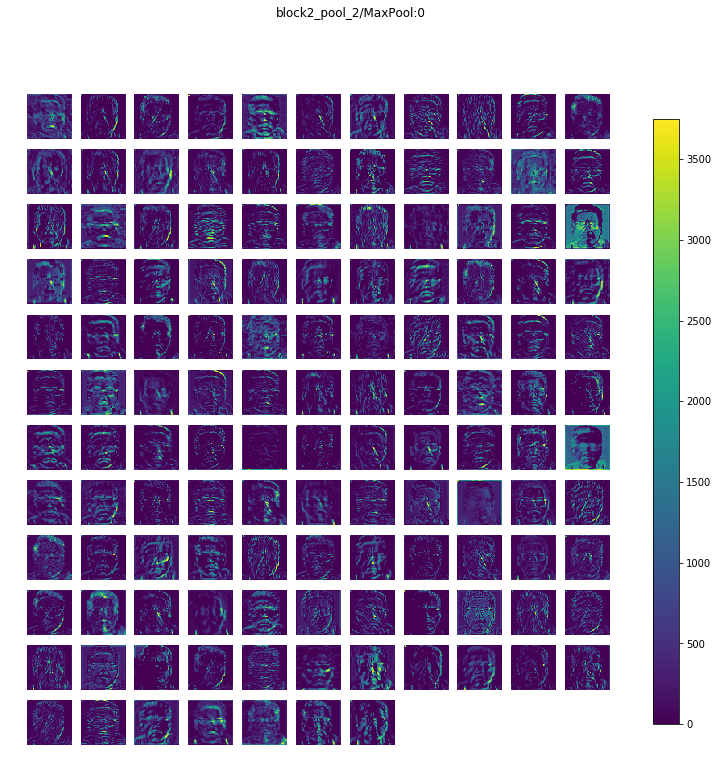

block3_conv1_2/Relu:0 (1, 56, 56, 256) 


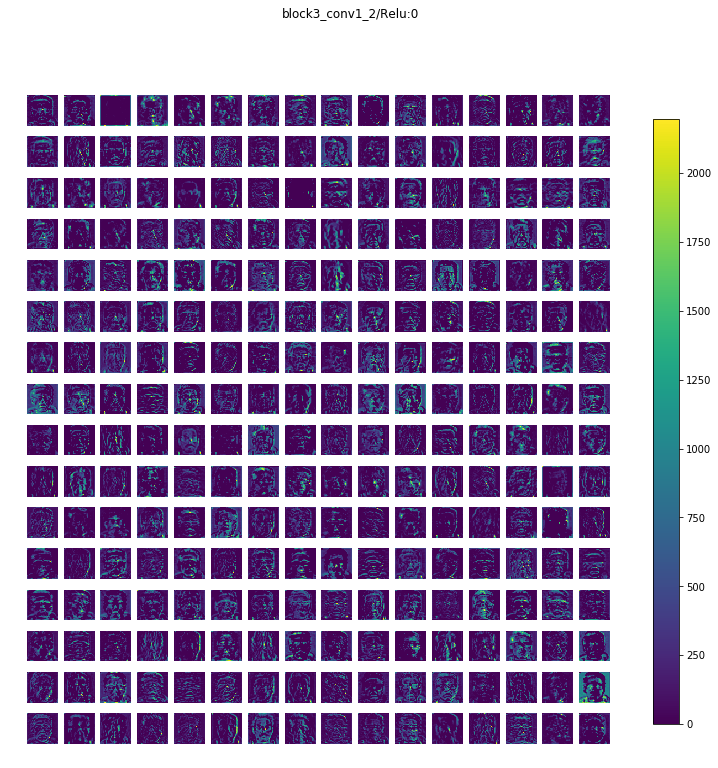

block3_conv2_2/Relu:0 (1, 56, 56, 256) 


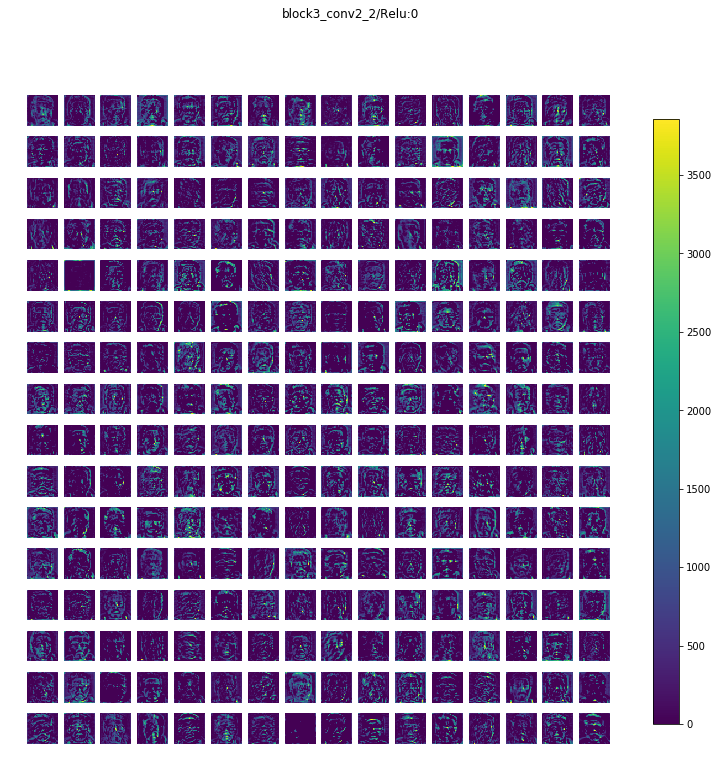

block3_conv3_2/Relu:0 (1, 56, 56, 256) 


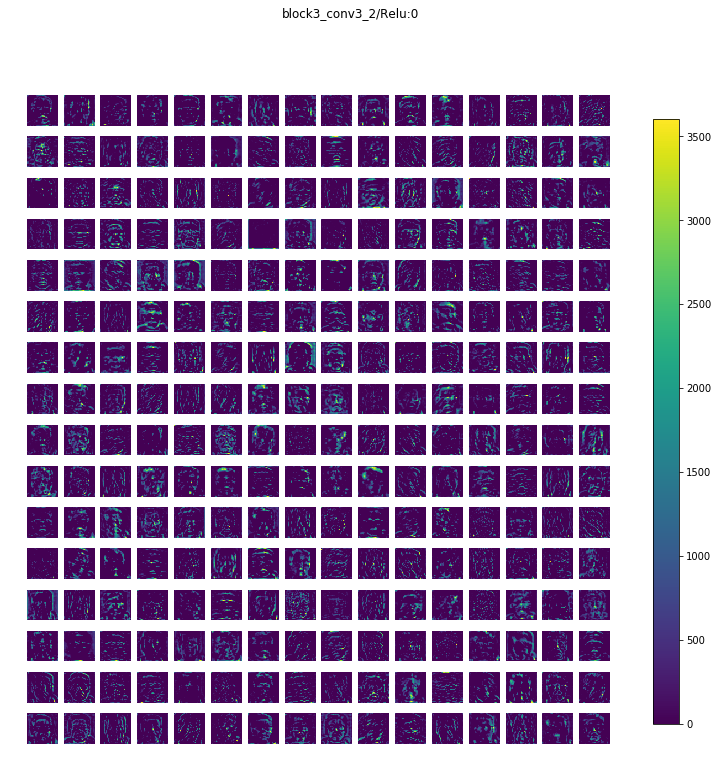

block3_pool_2/MaxPool:0 (1, 28, 28, 256) 


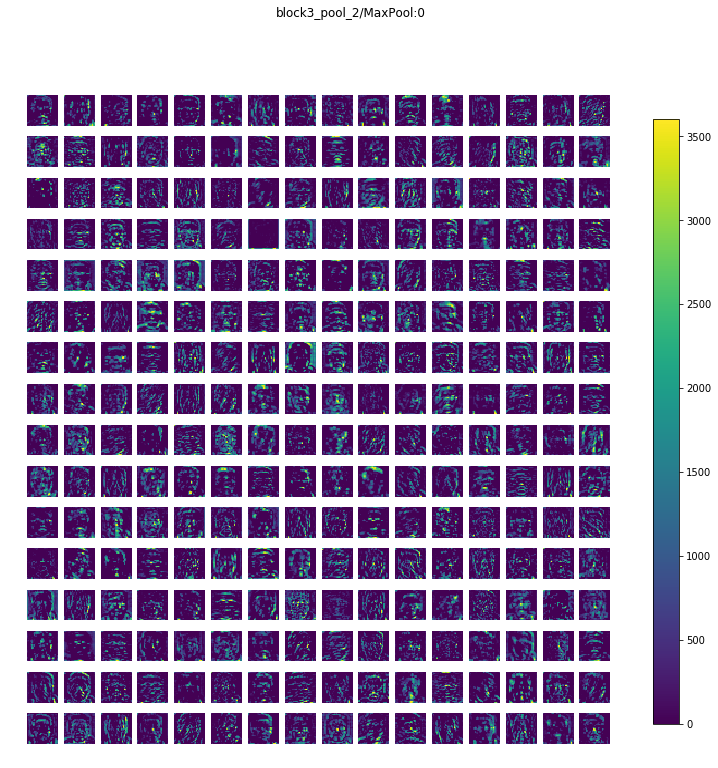

block4_conv1_2/Relu:0 (1, 28, 28, 512) 


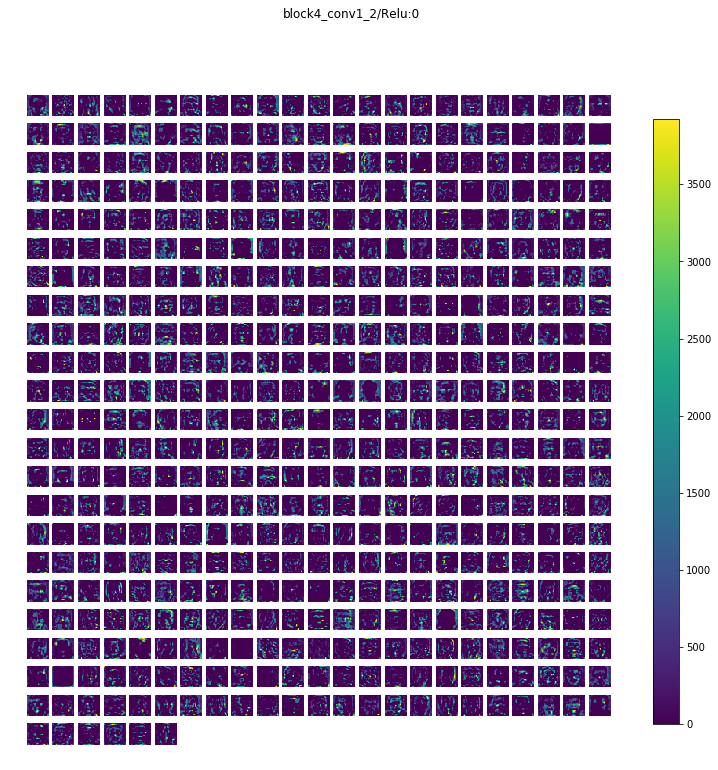

block4_conv2_2/Relu:0 (1, 28, 28, 512) 


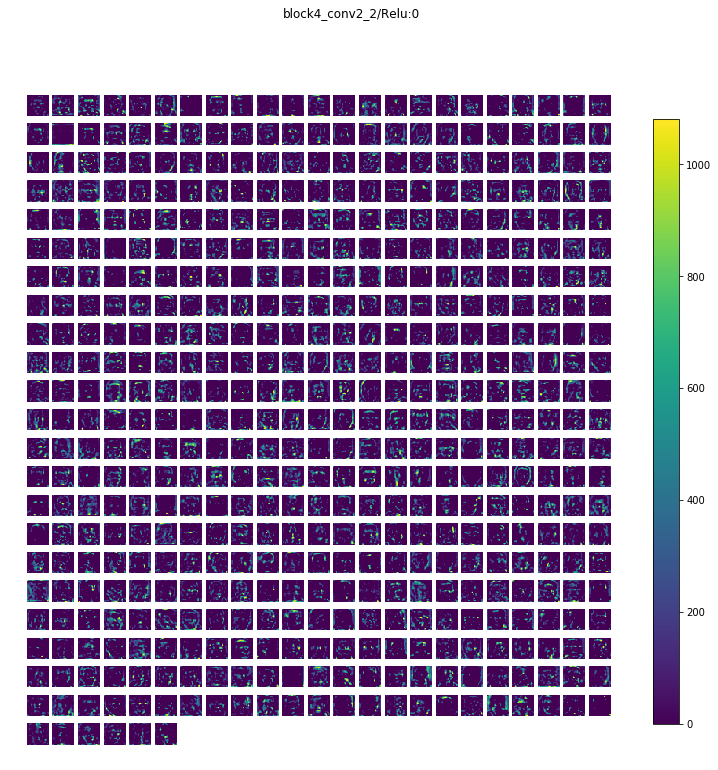

block4_conv3_2/Relu:0 (1, 28, 28, 512) 


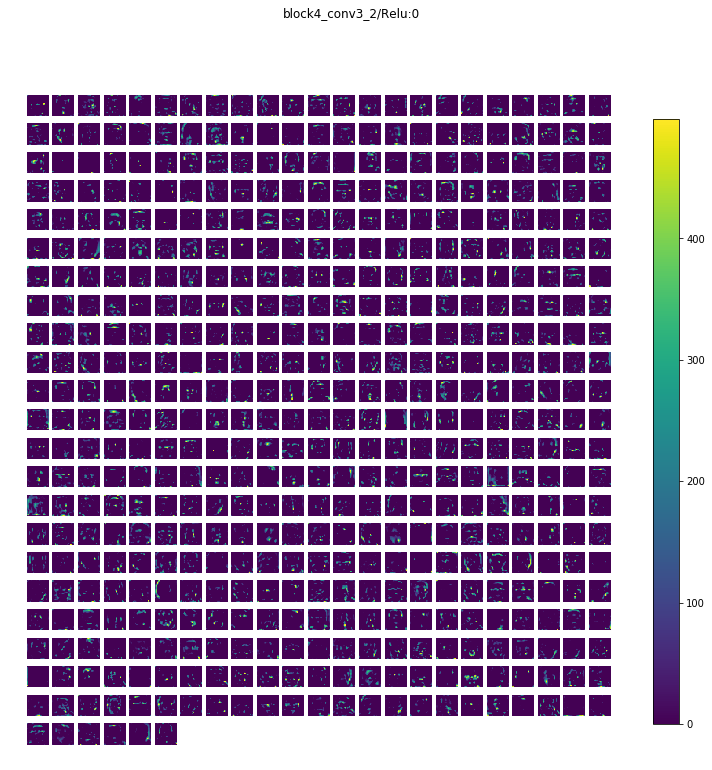

block4_pool_2/MaxPool:0 (1, 14, 14, 512) 


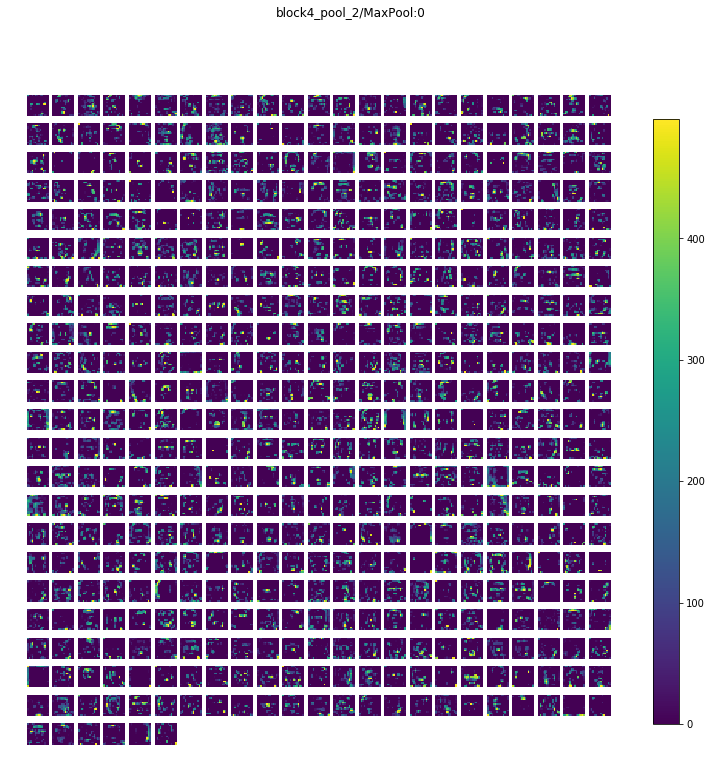

block5_conv1_2/Relu:0 (1, 14, 14, 512) 


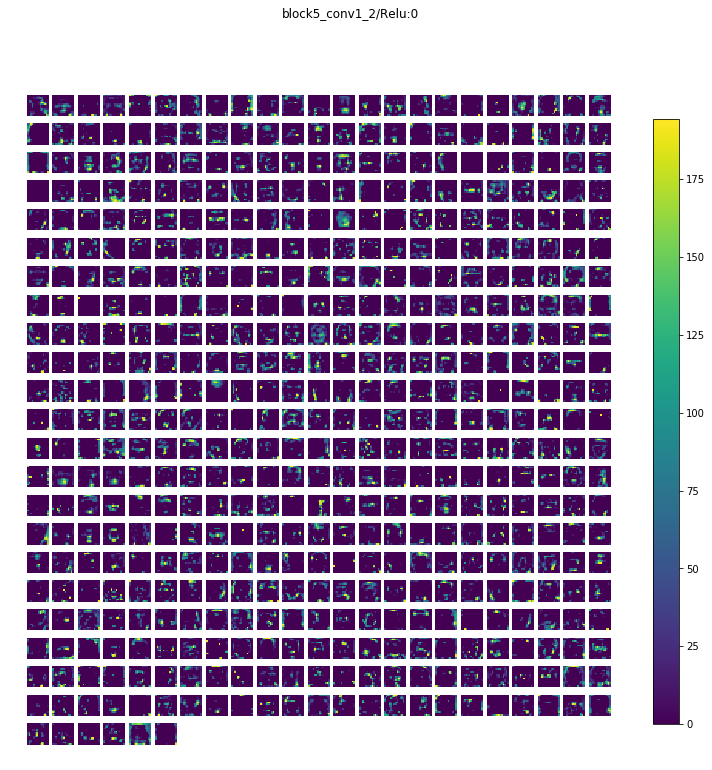

block5_conv2_2/Relu:0 (1, 14, 14, 512) 


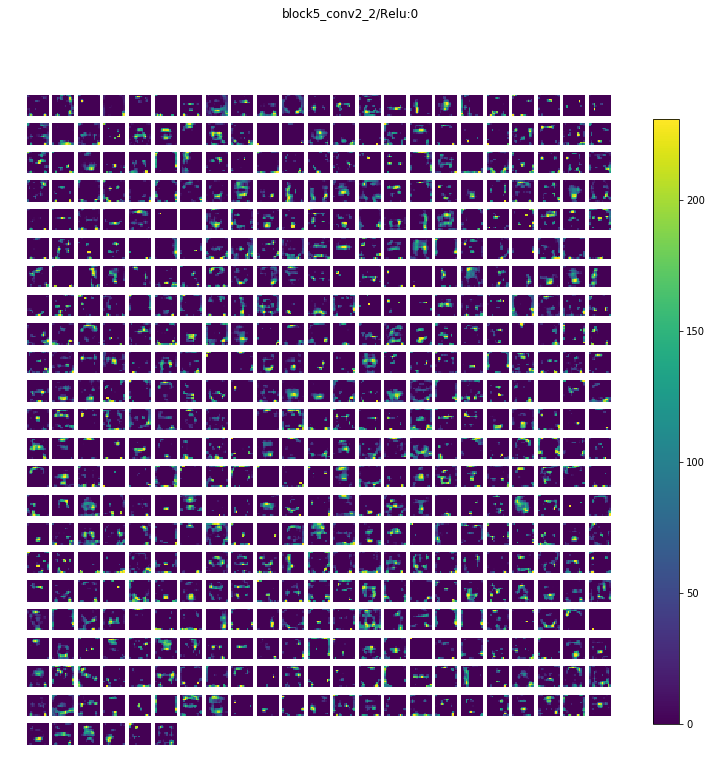

block5_conv3_2/Relu:0 (1, 14, 14, 512) 


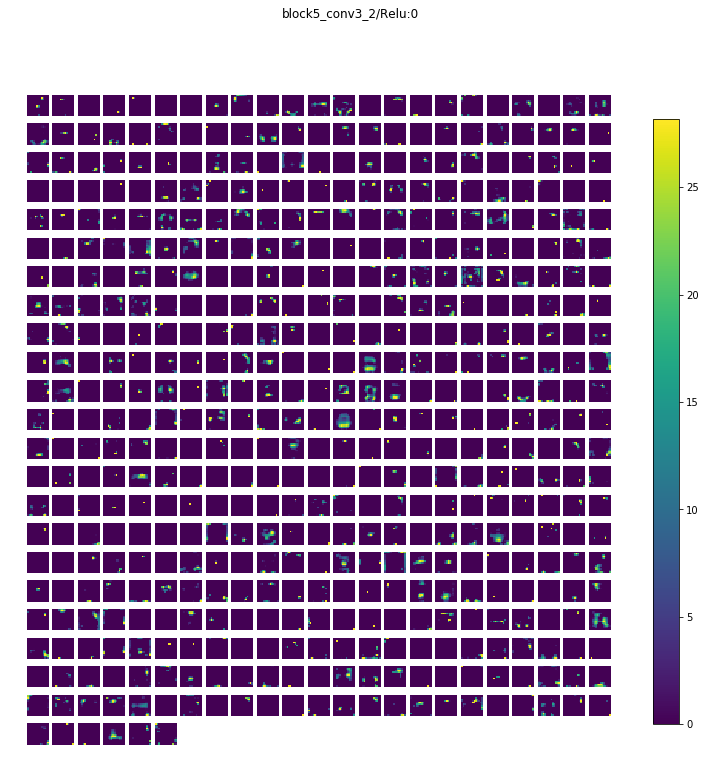

block5_pool_2/MaxPool:0 (1, 7, 7, 512) 


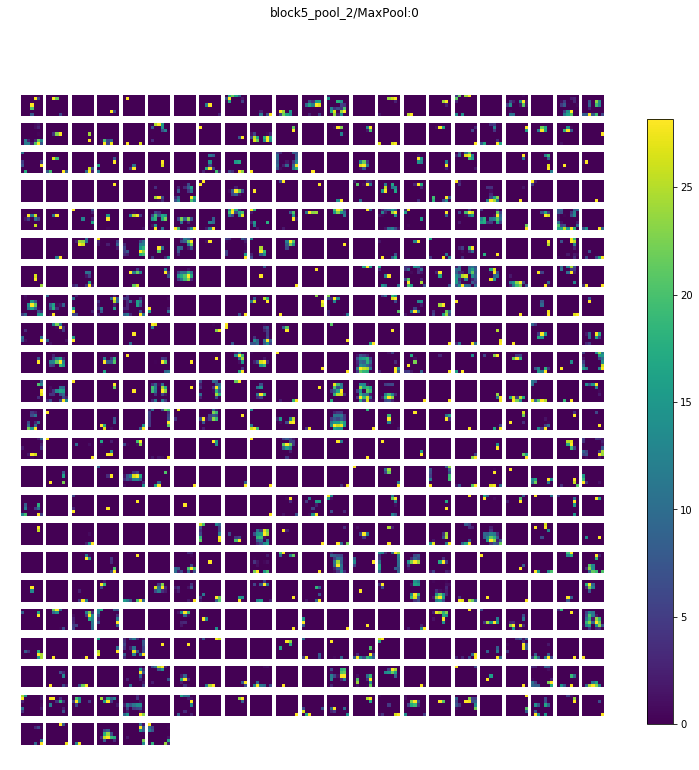

flatten_2/Reshape:0 (1, 25088) -> Skipped. 2D Activations.
fc1_2/Relu:0 (1, 4096) -> Skipped. 2D Activations.
fc2_2/Relu:0 (1, 4096) -> Skipped. 2D Activations.
predictions_2/Softmax:0 (1, 1000) -> Skipped. 2D Activations.


In [14]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import img_to_array

model = VGG16()

from PIL import Image
import requests
from io import BytesIO

# url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/1/14/Gatto_europeo4.jpg/250px-Gatto_europeo4.jpg'
#url = 'https://media.karousell.com/media/photos/products/2018/08/20/16_scale_tony_stark_avenger3_headscrupt_with_glasses_1534759826_e79b0cf4.jpg'
#response = requests.get(url)
#image = Image.open(BytesIO(response.content))
#image = image.crop((0, 0, 224, 224))

import cv2
image = cv2.imread('/content/drive/My Drive/Colab Notebooks/10. Visualizations/images/TonyStark.jpg')
image = cv2.resize(image,(224,224))

image = img_to_array(image)
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
image = preprocess_input(image)
yhat = model.predict(image)
label = decode_predictions(yhat)
label = label[0][0]
print('{} ({})'.format(label[1], label[2] * 100))

import keract

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
activations = keract.get_activations(model, image)
first = activations.get('block1_conv1/Relu:0')
keract.display_activations(activations)